### Use this markdown to generate the predictors


In [1]:
#imported libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
import langdetect
%matplotlib inline  
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Creating of the input data
downloads = pd.read_csv('train_app_downloads.csv')
reviews = pd.read_csv('train_app_review.csv')
ratings = pd.read_csv('train_app_rating.csv')
usages = pd.read_csv('train_usage.csv')
revenues = pd.read_csv('train_revenue.csv')
output = pd.read_csv('train_final_downloads.csv')
dateRange = pd.date_range('2015-03-01', periods=56).format(formatter=lambda x: x.strftime('%Y-%m-%d'))

sentiment = pd.read_csv('sentiment.csv',header=-1).ix[:,0]
sentiment.values[sentiment.values==0.0] = 0.5
reviews["sentiment_score"] = sentiment.values 

#We map -1 to 0 in the downloads (there are no 0 in the initial data)
replacementValue=0
downloads = downloads.replace(-1,replacementValue)

#Minor corrections
ratings = ratings.rename(columns={'start1': 'star1'})
ratings = pd.merge(downloads.drop(dateRange,1), ratings.drop('Unnamed: 0', 1), how='left',
                   on=["id","name","category"]).replace("NaN",replacementValue)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Initialize the predictors matrix

In [2]:
predictors = pd.concat([downloads["id"],downloads["name"],downloads["category"],downloads["device"]],
                       axis=1,keys=["id","name","category","device"])
predictors.head()

,id,name,category,device
0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone
1,281922769,Mobile MIM,Medical,ipad
2,281922769,Mobile MIM,Medical,iphone
3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad
4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone


#### Use the train_app_downloads.csv file

In [3]:
#Generate the logWeekly average
def generator_weekAvg(inp,w):
    if (np.count_nonzero(inp[5+w*7:12+w*7] - replacementValue*np.ones(len(inp[5+w*7:12+w*7]))) == 0):
        return 0
    return  math.log(1.0*sum(inp[5+w*7:12+w*7])/np.count_nonzero(inp[5+w*7:12+w*7] 
                                                                 - replacementValue*np.ones(len(inp[5+w*7:12+w*7]))))

for w in range(8):
    predictors["week_"+str(w+1)] = downloads.apply(generator_weekAvg,axis=1,args=(w,))

In [4]:
#Generate the daily average
def generator_dailyAvg(inp):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    return  (1.0*sum(inp[5:])/np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))))
    #return  math.log(1.0*sum(inp[5:])/len(inp[5:]))

predictors["daily_avg"] = downloads.apply(generator_dailyAvg,axis=1)
#This one is bad

In [5]:
#Generate the polynomial coefficients
def generator_coef(inp, coef):
    return  np.polyfit(range(56),inp[5:],coef)[0]
#Redo by ignoring the -1 / 0 ? w = [1110011]     w = np.not_equal(inp[5:],np.ones(len(inp[5:]))*replacementValue

for c in range(4):
    predictors["coef_"+str(c)] = downloads.apply(generator_coef,axis=1,args=(c,))

In [6]:
#Generate the step max and min (we ignore the values of 0)
def generator_maxStep(inp,maximum):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    m = 0
    for d in range(1,56):
        if (inp[5+d]!=replacementValue and inp[4+d]!=replacementValue):
            c = (inp[5+d]-inp[4+d])
            if (maximum and m < c):
                m = c
            if ( not maximum and m > c):
                m = c
    return m
                
predictors["maxStep"] = downloads.apply(generator_maxStep,axis=1,args=(True,))
predictors["minStep"] = downloads.apply(generator_maxStep,axis=1,args=(False,))

In [7]:
#Standard Deviation
def generator_std(inp):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    return np.std(inp[5:])

predictors["std"] = downloads.apply(generator_std,axis = 1)

In [8]:
#Number of missing Values
def generator_missing(inp):
    return list(inp[5:]).count(replacementValue)
    #return np.count_zero(inp[5:] -replacementValue*np.ones(len(inp[5:])))

predictors["nb_missing"] = downloads.apply(generator_missing,axis = 1)

In [9]:
#device
def generator_iphone(inp):
    if (inp[4] == "iphone"):
        return 1
    else:
        return 0

def generator_ipad(inp):
    if(inp[4] == "ipad"):
        return 1
    else:
        return 0
    
predictors["iphone"] = downloads.apply(generator_iphone,axis = 1)
predictors["ipad"] = downloads.apply(generator_ipad,axis = 1)

In [10]:
#Categories
def generator_categories(inp,cat):
    if (inp[3] == cat):
        return 1
    else:
        return 0
    

for cat in list(set(downloads["category"])):
    predictors[cat] = downloads.apply(generator_categories,axis = 1,args=(cat,))

In [11]:
def detect_language(x):
    try:
        detected = langdetect.detect(x.decode('utf8','ignore'))
        if detected in ['ja']:
            return 'japanese'
        elif detected in ['zh-cn']:
            return 'chinese'
        elif detected in ['ko']:
            return 'korean'
        return 'other'
    except:
        return None

def set_lang_categories(x, cat):
    if x == cat:
        return 1
    else:
        return 0
    
lang_series = predictors['name'].apply(detect_language)
for cat in list(set(lang_series)):
    predictors[cat] = lang_series.apply(set_lang_categories, args=(cat,))

#### Use the train_app_rating.csv file

In [12]:
avg_reviews = reviews.groupby('id').agg('mean')
avg_reviews['rating']
predictors['avg_review'] = predictors.join(avg_reviews['rating'],on='id')['rating'].replace("NaN",0)

In [13]:
avg_reviews = reviews.groupby('id').agg('var')
avg_reviews['rating']
predictors['var_review'] = predictors.join(avg_reviews['rating'],on='id')['rating'].replace("NaN",0)

In [14]:
ratings['num_ratings'] = ratings.ix[:,['star1','star2','star3','star4','star5']].sum(axis=1)

In [15]:
#raw ratings
predictors = pd.merge(predictors, ratings.drop('Unnamed: 0', 1), how='left',
                   on=["id","name","category","device"]).replace("NaN",replacementValue)

In [16]:
num_versions = reviews.groupby('id').version.nunique()
num_versions.name = 'num_versions'
predictors = predictors.join(num_versions, how='left', on='id')
predictors['num_versions'] = predictors['num_versions'].replace('NaN',0)

#### Use the sentiment score

In [17]:
#Later we can compute the weighted average of sentiment scores based on reviewers.
#add positive and negative columns to indicate the app's popularity
print reviews.ix[id==predictors.id[0],:]["sentiment_score"]
print reviews.ix[id==predictors.id[1],:]["sentiment_score"]
avg_score = [0]*predictors.shape[0]
predictors["positive"] = [0]*predictors.shape[0]
predictors["negative"] = [0]*predictors.shape[0]
for i in range(predictors.shape[0]):
    avg_score[i] = reviews.ix[reviews["id"]==predictors.id[i],:]["sentiment_score"].mean()
    if avg_score[i]>0.55: 
        predictors["positive"].values[i] = 1
    elif avg_score[i]<0.45: predictors["negative"].values[i] = 1
#predictors["avg_sentiment_score"] = avg_score

 

0.208647319075
0.208647319075


#### Use coeficients of metrics 

In [18]:
for i in range(4):
    predictors["m"+str(i+1)+"_max"] = np.zeros(predictors.shape[0]) 
    predictors["m"+str(i+1)+"_min"] = np.zeros(predictors.shape[0])
    predictors["m"+str(i+1)+"_mean"] = np.zeros(predictors.shape[0])
    predictors["m"+str(i+1)+"_std"] = np.zeros(predictors.shape[0])
    for j in range(3):
        predictors["m"+str(i+1)+"_coef_"+str(j)] = np.zeros(predictors.shape[0])

for i in range(predictors.shape[0]):
    if predictors["id"].values[i] not in usages["id"].values: continue
    for j in range(4):
        tmp = usages.ix[usages["id"] == predictors["id"].values[i],:]
        time_series = np.array(tmp.ix[tmp["metric"] == j+1,6:14])[0]   
        if -1 in time_series: continue
        X = np.array(range(8))
        fit = np.polyfit(X,time_series,2)
        for k in range(3):
            predictors["m"+str(j+1)+"_coef_"+str(k)].values[i] = fit[2-k]


In [19]:
print predictors.columns

Index([                u'id',               u'name',           u'category',
                   u'device',             u'week_1',             u'week_2',
                   u'week_3',             u'week_4',             u'week_5',
                   u'week_6',             u'week_7',             u'week_8',
                u'daily_avg',             u'coef_0',             u'coef_1',
                   u'coef_2',             u'coef_3',            u'maxStep',
                  u'minStep',                u'std',         u'nb_missing',
                   u'iphone',               u'ipad',       u'Productivity',
            u'Entertainment',             u'Travel',             u'Sports',
                    u'Music',           u'Shopping',            u'Finance',
                 u'Business',         u'Navigation',     u'Food and Drink',
                u'Utilities',          u'Newsstand', u'Health and Fitness',
                     u'News',          u'Lifestyle',            u'Medical',
            

#### Use coeficients of revenue

In [20]:
for j in range(3):
    predictors["rev_coef_"+str(j)] = np.zeros(predictors.shape[0])
    predictors["rev_max"] = np.zeros(predictors.shape[0])
    predictors["rev_min"] = np.zeros(predictors.shape[0])
    predictors["rev_mean"] = np.zeros(predictors.shape[0])
    predictors["rev_std"] = np.zeros(predictors.shape[0])
for i in range(predictors.shape[0]):
    
    if predictors["id"].values[i] in revenues["id"].values: 
        curr_rev  = revenues.ix[revenues["id"]== predictors["id"].values[i],:]
        if predictors["device"].values[i] in curr_rev["device"].values:
            curr_rev = curr_rev.ix[curr_rev["device"] == predictors["device"].values[i],:]
            time_series = np.array(curr_rev.ix[:,5:61])[0]
            if -1 in time_series: continue 
            X = np.array(range(56))
            fit = np.polyfit(X,time_series,2)
            for k in range(3):  predictors["rev_coef_"+str(k)].values[i] = fit[2-k]            

## To csv



In [21]:
predictors.to_csv("predictors.csv")

In [22]:
predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)

In [23]:
predictors.columns

Index([u'id', u'name', u'category', u'device', u'week_1', u'week_2', u'week_3',
       u'week_4', u'week_5', u'week_6', u'week_7', u'week_8', u'daily_avg',
       u'coef_0', u'coef_1', u'coef_2', u'coef_3', u'maxStep', u'minStep',
       u'std', u'nb_missing', u'iphone', u'ipad', u'Productivity',
       u'Entertainment', u'Travel', u'Sports', u'Music', u'Shopping',
       u'Finance', u'Business', u'Navigation', u'Food and Drink', u'Utilities',
       u'Newsstand', u'Health and Fitness', u'News', u'Lifestyle', u'Medical',
       u'Weather', u'Games', u'Catalogs', u'Social Networking',
       u'Photo and Video', u'Reference', u'Books', u'Education',
       u'Unnamed: 48', u'korean', u'other', u'japanese', u'chinese',
       u'avg_review', u'var_review', u'star1', u'star2', u'star3', u'star4',
       u'star5', u'num_ratings', u'num_versions', u'positive', u'negative',
       u'm1_max', u'm1_min', u'm1_mean', u'm1_std', u'm1_coef_0', u'm1_coef_1',
       u'm1_coef_2', u'm2_max', u'm2_min',

## How good did the predictor perform   --> Start running from here

In [24]:
#imported libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#Creating of the input data
downloads = pd.read_csv('train_app_downloads.csv')
reviews = pd.read_csv('train_app_review.csv')
ratings = pd.read_csv('train_app_rating.csv')
usages = pd.read_csv('train_usage.csv')
revenues = pd.read_csv('train_revenue.csv')
output = pd.read_csv('train_final_downloads.csv')
dateRange = pd.date_range('2015-03-01', periods=56).format(formatter=lambda x: x.strftime('%Y-%m-%d'))

sentiment = pd.read_csv('sentiment.csv',header=-1).ix[:,0]
sentiment.values[sentiment.values==0.0] = 0.5
reviews["sentiment_score"] = sentiment.values 

#We map -1 to 0 in the downloads (there are no 0 in the initial data)
replacementValue=0
downloads = downloads.replace(-1,replacementValue)

#Minor corrections
ratings = ratings.rename(columns={'start1': 'star1'})
ratings = pd.merge(downloads.drop(dateRange,1), ratings.drop('Unnamed: 0', 1), how='left',
                   on=["id","name","category"]).replace("NaN",replacementValue)

In [25]:
#This is the metric we use to determine our performance
def metric(y_pred,y_test,percent=1):
    top = int(len(y_pred)/100.0*percent)
    return (len(set([i[0] for i in sorted(enumerate(y_pred), key=lambda x:x[1],reverse=True)][0:top])
       .intersection([i[0] for i in sorted(enumerate(y_test), key=lambda x:x[1],reverse=True)][0:top])
               ))/(percent/100.0)/len(y_pred)*100

## Predictor selection

### Forward Predictor selection

In [92]:
predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)
predictors = predictors.fillna(0)

In [27]:
#Use a model to do a forward recursive predictor selection
mod=linear_model.Lasso(alpha=100,fit_intercept=False)
#mod=linear_model.LinearRegression(fit_intercept=False)
#mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100) 
#mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100) 
rfe = RFE(estimator=mod, n_features_to_select=1, step=1)
rfe.fit(predictors.as_matrix()[:,4:], output.as_matrix()[:,5])
ranking = rfe.ranking_

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [93]:
for e in [(i[0],i[1]) for i in sorted(zip(predictors.columns[4:],ranking),key=lambda x: x[1])]:
    print e

('m2_coef_0', 1)
('iphone', 2)
('Photo and Video', 3)
('Utilities', 4)
('Entertainment', 5)
('ipad', 6)
('week_1', 7)
('num_versions', 8)
('chinese', 9)
('Social Networking', 10)
('week_8', 11)
('News', 12)
('Medical', 13)
('Catalogs', 14)
('Navigation', 15)
('week_2', 16)
('Business', 17)
('Sports', 18)
('Reference', 19)
('Productivity', 20)
('other', 21)
('negative', 22)
('week_4', 23)
('Finance', 24)
('week_7', 25)
('week_3', 26)
('week_6', 27)
('avg_review', 28)
('week_5', 29)
('Education', 30)
('nb_missing', 31)
('coef_1', 32)
('var_review', 33)
('Music', 34)
('coef_2', 35)
('m3_coef_1', 36)
('Lifestyle', 37)
('coef_3', 38)
('coef_0', 39)
('m3_coef_0', 40)
('std', 41)
('Weather', 42)
('minStep', 43)
('rev_coef_1', 44)
('Shopping', 45)
('rev_coef_0', 46)
('Games', 47)
('daily_avg', 48)
('star3', 49)
('star2', 50)
('star4', 51)
('Health and Fitness', 52)
('maxStep', 53)
('m4_coef_2', 54)
('m4_coef_1', 55)
('star1', 56)
('num_ratings', 57)
('m1_coef_0', 58)
('m4_coef_0', 59)
('star5'

In [94]:
#manually drop predictors 
#predictors_to_drop = []
nb_pred_to_keep = 60
predictors_to_drop = [i[0] for i in sorted(zip(predictors.columns[4:],ranking),key=lambda x: x[1])][nb_pred_to_keep:]
for col in predictors_to_drop:
    predictors = predictors.drop(col,1)
    

### Other predictor selection method using Lasso

In [84]:
# Other method
predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)
predictors = predictors.fillna(0)
#var_select = linear_model.Lasso(alpha = 0.01).fit(predictor_train_top_10_precent.as_matrix()[:,4:],np.log(output_train_top_10_precent["cumulative_downloads_2016-02"].as_matrix()))
var_select = linear_model.Lasso(alpha = 1).fit(predictor_train_top_10_precent.as_matrix()[:,4:],np.log(output_train_top_10_precent["cumulative_downloads_2016-02"].as_matrix()))

importance_list = [i for i in range(len(var_select.coef_)) if abs(var_select.coef_[i])>0]
important_predictors = [predictors.columns.values[i+4] for i in range(len(var_select.coef_)) if (i in importance_list)]
print important_predictors
for col in predictors.columns.values[4:]:
    if col not in important_predictors:
        predictors = predictors.drop(col,1)

['week_8', 'daily_avg', 'coef_2', 'coef_3', 'maxStep', 'iphone', 'Entertainment', 'Travel', 'Sports', 'Finance', 'Business', 'Food and Drink']


In [95]:
predictors.columns.values

array(['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3',
       'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg',
       'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std',
       'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment',
       'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation',
       'Utilities', 'Health and Fitness', 'News', 'Lifestyle', 'Medical',
       'Weather', 'Games', 'Catalogs', 'Social Networking',
       'Photo and Video', 'Reference', 'Education', 'other', 'chinese',
       'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4',
       'star5', 'num_ratings', 'num_versions', 'negative', 'm1_coef_0',
       'm2_coef_0', 'm3_coef_0', 'm3_coef_1', 'm4_coef_0', 'm4_coef_1',
       'm4_coef_2', 'rev_coef_0', 'rev_coef_1'], dtype=object)

# Classification + Regression

In [99]:
print list(predictors.columns.values) 

np.random.seed(1)

K = 5

top_percent_classif = 20


kf = KFold(len(predictors), n_folds=K)
old_top = []
new_top = []
top_10 = []
new_top_select = [] 
new_top_noClassif = []
for train, test in kf:
    #base model
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:12], output.as_matrix()[train,5])
    old_y_pred =  old_mod.predict(predictors.as_matrix()[test,4:12])
    old_top.append(metric(old_y_pred,output.as_matrix()[test,5]))
    
    #model to determine the top 10%       (Use only the weeks ?)
    #mod_class10= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
    mod_class10= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:12], output.as_matrix()[train,5])
    
    #y_pred =  mod_class10.predict(predictors.as_matrix()[test,4:])
    y_pred =  mod_class10.predict(predictors.as_matrix()[test,4:12])
    
    #estimate of the top 10% of the test set
    estimate_class10 = predictors.iloc[test].copy()
    estimate_class10["firstEstimate"] = y_pred
    #estimate_class10 = estimate_class10.sort_values(by= "firstEstimate",ascending = False).iloc[1:int(1.0*top_percent_classif/100.0*len(estimate_class10))]
    estimate_class10 = estimate_class10.drop("firstEstimate",1)
    estimate_class10 = estimate_class10.sort_values(by= "daily_avg",ascending = False).iloc[1:int(1.0*top_percent_classif/100.0*len(estimate_class10))]

    
    #top 10% of the trainning set
    output_train_top_10_precent = output.iloc[train].copy().sort_values(by= 'cumulative_downloads_2016-02',ascending = False).iloc[1:int(1.0*top_percent_classif/100.0*len(output.iloc[train]))].drop('Unnamed: 0',1)
    predictor_train_top_10_precent = output_train_top_10_precent.merge(predictors, how='left', on=["id","name","category","device"]).copy()
    predictor_train_top_10_precent = predictor_train_top_10_precent.drop('cumulative_downloads_2016-02',1)
    #predictor_train_top_10_precent = predictor_train_top_10_precent.drop('firstEstimate',1)
    

    #This is the actual top 1% of the test set
    output_test_top_1_precent = output.iloc[test].sort_values(by= 'cumulative_downloads_2016-02',ascending = False).iloc[1:int(0.01*len(output.iloc[test]))].copy()

    #second model
    #mod_top1= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictor_train_top_10_precent.as_matrix()[:,4:], output_train_top_10_precent["cumulative_downloads_2016-02"].as_matrix())
    #mod_top1=linear_model.Lasso(alpha=100,fit_intercept=False).fit(predictor_train_top_10_precent.as_matrix()[:,4:], np.log(output_train_top_10_precent["cumulative_downloads_2016-02"].as_matrix()))
    #mod_top1=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(predictor_train_top_10_precent.as_matrix()[:,4:], (output_train_top_10_precent["cumulative_downloads_2016-02"].as_matrix()))
    mod_top1= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictor_train_top_10_precent.as_matrix()[:,4:], np.log(output_train_top_10_precent["cumulative_downloads_2016-02"].as_matrix()))
    #mod_top1= linear_model.LinearRegression(fit_intercept=False).fit(predictor_train_top_10_precent.as_matrix()[:,4:12], (output_train_top_10_precent["cumulative_downloads_2016-02"].as_matrix()))

    y_pred_2 =  mod_top1.predict(estimate_class10.as_matrix()[:,4:])
    
    
    #third model , additionnal predictor selection using lasso
    var_select = linear_model.Lasso(alpha = 0.01).fit(predictor_train_top_10_precent.as_matrix()[:,4:],np.log(output_train_top_10_precent["cumulative_downloads_2016-02"].as_matrix()))
    importance_list = [i for i in  range(len(var_select.coef_)) if abs(var_select.coef_[i])>0]                                       
    X_rf_train = predictor_train_top_10_precent.as_matrix()[:,4:][:,importance_list]
    y_rf_train = output_train_top_10_precent["cumulative_downloads_2016-02"].as_matrix()
    X_rf_test = estimate_class10.as_matrix()[:,4:][:,importance_list]  
    
    #mod_top1_select= RandomForestRegressor(max_features = "sqrt",n_estimators = 100).fit(X_rf_train, y_rf_train)
    params = {'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.015, 'loss': 'ls'}
    mod_top1_select= GradientBoostingRegressor(**params).fit(X_rf_train, y_rf_train)
    y_pred_3 = mod_top1_select.predict(X_rf_test)
    
    
    #No Classification model
    mod_noClassif= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
    y_pred_noClassif =  mod_noClassif.predict(predictors.as_matrix()[test,4:])

    
    
    estimate_top1 = estimate_class10.copy()
    estimate_top1_select = estimate_class10.copy()
    estimate_top1_noClassif = predictors.iloc[test].copy()
    estimate_top1["secondEstimate"] = y_pred_2
    estimate_top1_select["thirdEstimate"] = y_pred_3
    estimate_top1_noClassif["noClassifEstimate"] = y_pred_noClassif
    estimate_top1 = estimate_top1.sort_values(by= "secondEstimate",ascending = False).iloc[1:int(0.01*len(output.iloc[test]))]
    estimate_top1_select = estimate_top1_select.sort_values(by= "thirdEstimate",ascending = False).iloc[1:int(0.01*len(output.iloc[test]))]
    estimate_top1_noClassif = estimate_top1_noClassif.sort_values(by= "noClassifEstimate",ascending = False).iloc[1:int(0.01*len(output.iloc[test]))]

    estimation_error = len(estimate_top1.merge(output_test_top_1_precent, how='inner', on=["id","name","category","device"]))*100.0/len(output_test_top_1_precent)
    new_top.append(estimation_error)
    new_top_select.append(len(estimate_top1_select.merge(output_test_top_1_precent, how='inner', on=["id","name","category","device"]))*100.0/len(output_test_top_1_precent))
    new_top_noClassif.append(len(estimate_top1_noClassif.merge(output_test_top_1_precent, how='inner', on=["id","name","category","device"]))*100.0/len(output_test_top_1_precent))
    top_10.append(len(estimate_class10.merge(output_test_top_1_precent, how='inner', on=["id","name","category","device"]))*100.0/len(output_test_top_1_precent))
       
print "Old model           : " + str(1.0*sum(old_top)/len(old_top))
print "Top10%              : " + str(1.0*sum(top_10)/len(top_10))
print "Top1% with classif1 : " + str(1.0*sum(new_top)/len(new_top))
print "Top1% with classif2 : " + str(1.0*sum(new_top_select)/len(new_top_select))
print "Top1% no classif1   : " + str(1.0*sum(new_top_noClassif)/len(new_top_noClassif))

['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Utilities', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Education', 'other', 'chinese', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'num_ratings', 'num_versions', 'negative', 'm1_coef_0', 'm2_coef_0', 'm3_coef_0', 'm3_coef_1', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2', 'rev_coef_0', 'rev_coef_1']
Old model           : 54.4232031342
Top10%              : 97.4603174603
Top1% with classif1 : 55.2380952381
Top1% with classif2 : 53.9682539683
Top1% no classif1   : 54.2857142857


5 fold 60 pred forward selection top 20% Classif <br/>
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Utilities', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Education', 'other', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'num_ratings', 'num_versions', 'positive', 'm1_max', 'm1_coef_1', 'm3_max', 'm3_min', 'm4_max', 'm4_min', 'rev_coef_0', 'rev_max', 'rev_min', 'rev_mean'] <br/>
Old model          :  54.4232031342 <br/>
Top10%             :  98.4126984127 <br/>
Top1% with classif1 : 56.5079365079 <br/>
Top1% with classif1 : 53.6507936508 <br/>
Top1% no classif1   : 54.6031746032 <br/>

10 fold 60 pred forward selection top 20% Classif <br/>
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Utilities', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Education', 'other', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'num_ratings', 'num_versions', 'positive', 'm1_max', 'm1_coef_1', 'm3_max', 'm3_min', 'm4_max', 'm4_min', 'rev_coef_0', 'rev_max', 'rev_min', 'rev_mean']<br/>
Old model           : 55.0415369027<br/>
Top10%              : 97.7419354839<br/>
Top1% with classif1 : 52.2580645161<br/>
Top1% with classif1 : 52.2580645161<br/>
Top1% no classif1   : 54.1935483871<br/>

5 fold 60 pred forward selection top 10% Classif <br/>
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Utilities', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Education', 'other', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'num_ratings', 'num_versions', 'positive', 'm1_max', 'm1_coef_1', 'm3_max', 'm3_min', 'm4_max', 'm4_min', 'rev_coef_0', 'rev_max', 'rev_min', 'rev_mean']<br/>
Old model           : 54.4232031342<br/>
Top10%              : 95.873015873<br/>
Top1% with classif1 : 53.9682539683<br/>
Top1% with classif2 : 53.9682539683<br/>
Top1% no classif1   : 54.6031746032<br/>

5 fold Lasso Selection alpha 0.01 top 20% Classif <br/>
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'maxStep', 'minStep', 'std', 'nb_missing', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'num_ratings', 'num_versions', 'm3_coef_0', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2', 'rev_coef_0', 'rev_coef_1']<br/>
Old model           : 52.2586053413<br/>
Top10%              : 98.0952380952<br/>
Top1% with classif1 : 53.9682539683<br/>
Top1% with classif2 : 54.6031746032<br/>
Top1% no classif1   : 54.6031746032<br/>

5 fold Lasso Selection alpha 1 top 20% Classif <br/>
['id', 'name', 'category', 'device', 'week_8', 'daily_avg', 'coef_2', 'coef_3', 'maxStep', 'iphone', 'Entertainment', 'Travel', 'Sports', 'Finance', 'Business', 'Food and Drink']<br/>
Old model           : 51.3309615565<br/>
Top10%              : 98.0952380952<br/>
Top1% with classif1 : 51.1111111111<br/>
Top1% with classif2 : 51.4285714286<br/>
Top1% no classif1   : 51.4285714286<br/>

5 fold no selection top 20% Classif <br/>
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'Unnamed: 48', 'korean', 'other', 'japanese', 'chinese', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'num_ratings', 'num_versions', 'positive', 'negative', 'm1_max', 'm1_min', 'm1_mean', 'm1_std', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_max', 'm2_min', 'm2_mean', 'm2_std', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_max', 'm3_min', 'm3_mean', 'm3_std', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_max', 'm4_min', 'm4_mean', 'm4_std', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2', 'rev_coef_0', 'rev_max', 'rev_min', 'rev_mean', 'rev_std', 'rev_coef_1', 'rev_coef_2'] <br/>
Old model           : 54.4232031342 <br/>
Top10%              : 98.4126984127 <br/>
Top1% with classif1 : 52.6984126984 <br/>
Top1% with classif2 : 54.6031746032 <br/>
Top1% no classif1   : 54.9206349206 <br/>

5 fold 60 Lasso forward selection top 20% Classif using daily_avg <br/>
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Utilities', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Education', 'other', 'chinese', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'num_ratings', 'num_versions', 'negative', 'm1_coef_0', 'm2_coef_0', 'm3_coef_0', 'm3_coef_1', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2', 'rev_coef_0', 'rev_coef_1']
Old model           : 54.4232031342
Top10%              : 98.7301587302
Top1% with classif1 : 57.1428571429
Top1% with classif2 : 55.5555555556
Top1% no classif1   : 54.2857142857

In [31]:
var_select.coef_

array([  3.79192033e-02,   9.43077583e-03,   1.94620058e-02,
         1.31819818e-03,   1.16254853e-02,   1.21511917e-02,
         1.22076724e-02,   2.35418757e-02,   3.01848389e-05,
         2.48164894e-04,   6.69595077e-04,   1.18604174e-02,
         0.00000000e+00,  -4.65398424e-05,  -2.65905056e-04,
         1.06136809e-02,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
         5.36097492e-04,   2.50600480e-03,   6.74864033e-06,
         3.54496950e-06,   5.19260334e-03,  -0.00000000e+00,
         0.00000000e+00,   2.31305427e-04,   0.00000000e+00,
         2.25306532e-05,

In [32]:
len(predictor_train_top_10_precent)

5173

## Cross Validation k-folds

In [ ]:

np.random.seed(1)
print list(predictors.columns.values)

K = 10

kf = KFold(len(predictors), n_folds=K)
old_top = []
new_top = []
for train, test in kf:
    #base model
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:12], output.as_matrix()[train,5])
    old_y_pred =  old_mod.predict(predictors.as_matrix()[test,4:12])
    old_top.append(metric(old_y_pred,output.as_matrix()[test,5]))
    #model
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
    #mod=linear_model.Lasso(alpha=100,fit_intercept=False).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
    #mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
    #mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
    mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
    y_pred =  mod.predict(predictors.as_matrix()[test,4:])
    new_top.append(metric(y_pred,output.as_matrix()[test,5]))
print 1.0*sum(old_top)/len(old_top)
print 1.0*sum(new_top)/len(new_top)

10
['id', 'name', 'category', 'device', 'week_1', 'iphone', 'ipad', 'Entertainment', 'Utilities', 'Social Networking', 'Photo and Video', 'chinese', 'num_versions', 'm2_coef_0']
33.0867268033
38.6527807985
 
15
['id', 'name', 'category', 'device', 'week_1', 'iphone', 'ipad', 'Entertainment', 'Utilities', 'Social Networking', 'Photo and Video', 'chinese', 'num_versions', 'm2_coef_0']
33.0867268033
38.6527807985
 
20
['id', 'name', 'category', 'device', 'week_1', 'iphone', 'ipad', 'Entertainment', 'Utilities', 'Social Networking', 'Photo and Video', 'chinese', 'num_versions', 'm2_coef_0']
33.0867268033
38.6527807985
 
25
['id', 'name', 'category', 'device', 'week_1', 'iphone', 'ipad', 'Entertainment', 'Utilities', 'Social Networking', 'Photo and Video', 'chinese', 'num_versions', 'm2_coef_0']
33.0867268033
38.6527807985
 
30
['id', 'name', 'category', 'device', 'week_1', 'iphone', 'ipad', 'Entertainment', 'Utilities', 'Social Networking', 'Photo and Video', 'chinese', 'num_versions', 'm2

## Cross Validation k-folds testing optimal nb_predictor

In [51]:

for nb in range(10,94,5):

    predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)
    predictors = predictors.fillna(0)
    
    nb_pred_to_keep = nb
    predictors_to_drop = [i[0] for i in sorted(zip(predictors.columns[4:],ranking),key=lambda x: x[1])][nb_pred_to_keep:]
    for col in predictors_to_drop:
        predictors = predictors.drop(col,1)



    np.random.seed(1)
    print nb
    print list(predictors.columns.values)

    K = 10

    kf = KFold(len(predictors), n_folds=K)
    old_top = []
    new_top = []
    for train, test in kf:
        #base model
        old_mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:12], output.as_matrix()[train,5])
        old_y_pred =  old_mod.predict(predictors.as_matrix()[test,4:12])
        old_top.append(metric(old_y_pred,output.as_matrix()[test,5]))
        #model
        #mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
        #mod=linear_model.Lasso(alpha=100,fit_intercept=False).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
        #mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
        #mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
        mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
        y_pred =  mod.predict(predictors.as_matrix()[test,4:])
        new_top.append(metric(y_pred,output.as_matrix()[test,5]))
    print 1.0*sum(old_top)/len(old_top)
    print 1.0*sum(new_top)/len(new_top)
    print " "

10
['id', 'name', 'category', 'device', 'week_1', 'iphone', 'ipad', 'Entertainment', 'Utilities', 'Social Networking', 'Photo and Video', 'chinese', 'num_versions', 'm2_coef_0']
33.0867268033
38.6527807985
 
15
['id', 'name', 'category', 'device', 'week_1', 'week_8', 'iphone', 'ipad', 'Entertainment', 'Navigation', 'Utilities', 'News', 'Medical', 'Catalogs', 'Social Networking', 'Photo and Video', 'chinese', 'num_versions', 'm2_coef_0']
40.1994276326
51.9493909534
 
20
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_8', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Business', 'Navigation', 'Utilities', 'News', 'Medical', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'chinese', 'num_versions', 'm2_coef_0']
45.1468611515
52.8772260247
 
25
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_4', 'week_7', 'week_8', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Finance', 'Business', 'Navigation', 'Utilities', 'New

K=10 
Random Forest sqrt  :mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
PPredictors obtainned with top 50 on Lasso
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Utilities', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star2', 'star3', 'star4', 'positive', 'negative', 'm2_coef_0', 'm3_coef_0', 'm3_coef_1', 'rev_coef_0', 'rev_coef_1']
58.1337784952

# Old Testing model

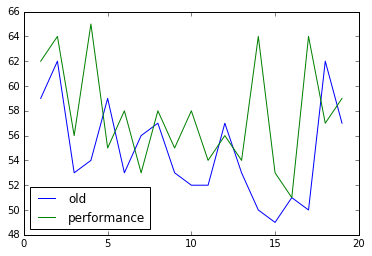

54.6842105263
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Utilities', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Education', 'other', 'chinese', 'avg_review', 'var_review', 'star2', 'star3', 'num_versions', 'negative', 'm2_coef_0', 'm3_coef_0', 'm3_coef_1', 'rev_coef_0', 'rev_coef_1']
57.6842105263


In [33]:
old_top = []
new_top = []

test_frac = 0.31  #Fraction of test points
N = 20   #number of iterations
np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,429496729)
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:12], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    X_test = X_test[0:10000]
    y_test = y_test[0:10000]
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    old_y_pred =  old_mod.predict(X_test)
    old_top.append(metric(old_y_pred,y_test))
    
np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,429496729)
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    X_test = X_test[0:10000]
    y_test = y_test[0:10000]
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    #mod=linear_model.Lasso(alpha=100,fit_intercept=False).fit(X_train,y_train)
    #mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100).fit(X_train,y_train)
    mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(X_train,y_train)
    y_pred =  mod.predict(X_test)
    new_top.append(metric(y_pred,y_test))
if (N<300):
    fig = plt.figure()
    plt.plot(range(1,N),old_top,label="old")
    plt.plot(range(1,N),new_top,label="performance")
    plt.legend(loc='best')
    plt.show()

print 1.0*sum(old_top)/len(old_top)
print list(predictors.columns.values)
print 1.0*sum(new_top)/len(new_top)

54.8947368421  
55.0526315789  #with #missing and Lasso <br/>
54.7894736842  #including raw ratings Lasso :( <br/>
55.0526315789  #with #missing weightedSumRatings and Lasso <br/>
55.1052631579  #adding the categories <br/>
55.3684210526  #adding average sentiment score and positive/negative label <br/>
55.5263157895  #adding coeficients of usages


With 10000 only:
54.8947368421 all

56.5263157895 on Lasso all but 'rev_coef_i'

Lasso All alpha = 100
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'positive', 'negative', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2']
57.1052631579

Predictor selection, pick the top 50 features selected in the forward recursive selection with Lasso and then do random forest

54.6842105263
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Education', 'avg_review', 'var_review', 'star2', 'star3', 'star4', 'positive', 'negative', 'm2_coef_0', 'm3_coef_0', 'm3_coef_1', 'm4_coef_2']
57.3157894737

In [34]:
#Estimation of alpha for the Lasso regression "cros validation" like approach
for a in np.arange(90,110,5):

    old_top = []
    new_top = []

    test_frac = 0.31  #Fraction of test points
    N = 20   #number of iterations


    np.random.seed(1)
    for i in range(1,N):
        r = np.random.randint(1,429496729)
        X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
        X_test = X_test[0:10000]
        y_test = y_test[0:10000]
        mod=linear_model.Lasso(alpha=a,fit_intercept=False).fit(X_train,y_train) 
        y_pred =  mod.predict(X_test)
        new_top.append(metric(y_pred,y_test))


    print a
    print 1.0*sum(new_top)/len(new_top)
    print " "

90
55.7894736842
 
95
55.7894736842
 
100
55.7368421053
 
105
55.7368421053
 


# Lasso all
53.4375
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'positive', 'negative', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2']
54.0625

## Attempt at boosting

In [ ]:
#Boosting

from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

new_top = []

test_frac = 0.31  #Fraction of test points
N = 20   #number of iterations



np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,429496729)
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    X_test = X_test[0:10000]
    y_test = y_test[0:10000]
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    #mod=linear_model.Lasso(alpha=a,fit_intercept=False).fit(X_train,y_train) 
    mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(X_train,y_train)
    mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100) 
    y_pred =  mod.predict(X_test)
    new_top.append(metric(y_pred,y_test))

print 1.0*sum(new_top)/len(new_top)
print " "


In [ ]:
output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False).head(1)


In [ ]:
predictors.columns


# Making Classification on top 10%

In [ ]:
predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)
predictors = predictors.fillna(0)

thr = predictors.sort_values(by= 'week_8',ascending = False).iloc[int(0.1*len(predictors))]["week_8"]
predictors  = predictors[predictors.week_8 >= thr]


len(predictors)

In [ ]:
output_classification_10 = output
output_classification_50 = output
output_classification_100 = output
#Is top ?
def generator_istop(inp,threshold):
    if (inp[5] >= threshold):
        return 'True'
    else:
        return 'False'

threshold = output.sort_values('cumulative_downloads_2016-02',ascending = False).iloc[len(output)/10]['cumulative_downloads_2016-02']
output_classification_10["is_top"] = output.apply(generator_istop,axis = 1,args=(threshold,))

threshold = output.sort_values('cumulative_downloads_2016-02',ascending = False).iloc[len(output)/50]['cumulative_downloads_2016-02']
output_classification_50["is_top"] = output.apply(generator_istop,axis = 1,args=(threshold,))

threshold = output.sort_values('cumulative_downloads_2016-02',ascending = False).iloc[len(output)/100]['cumulative_downloads_2016-02']
output_classification_100["is_top"] = output.apply(generator_istop,axis = 1,args=(threshold,))

In [ ]:
output_classification_10.head()

In [ ]:
from sklearn.svm import SVC
K=10
kf = KFold(32339, n_folds=K)
old_top = []
new_top = []
for train, test in kf:
    #model
    mod = SVC(C=10.0, kernel='poly', degree=3, gamma='auto', coef0=2.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=10, decision_function_shape=None, random_state=None).fit(predictors.as_matrix()[train,4:],output_classification_10.as_matrix()[train,6])
    #mod = linear_model.LogisticRegression().fit(predictors.as_matrix()[train,4:], output_classification_10.as_matrix()[train,6])
    y_pred =  mod.predict(predictors.as_matrix()[test,4:])
    new_top.append(metric_classification(y_pred,output_classification_10.as_matrix()[test,6]))
print list(predictors.columns.values)
print 1.0*sum(new_top)/len(new_top)


In [ ]:
###This metric is not very good, put True everywhere and get 100%
def metric_classification(y_pred,y_test):
    nb_top = 0
    for i in range(len(y_test)):
        if (y_pred[i]=='True' and y_test[i]=="False"):
            nb_top+=1
    return 100.0*nb_top/len(y_pred)


In [ ]:
list(y_pred).count("False")*1.0/len(y_pred)

In [ ]:
print list(y_pred).count('True')
print list(output_classification_10.as_matrix()[test,6]).count('True')
print len(y_pred)

Question, what if instead of using the 'cumulative_downloads_2016-02' we used exp('cumulative_downloads_2016-02') to try to shrunk the lowest points?


In [ ]:
output_scaled = output
#Is top ?
def generator_outputScaler(inp):
    #return math.exp(inp[5]*1.0/12329752*100)   #28%
    #return 1.0/(20000000-inp[5])   #0.618429189858
    #return inp[5]**2       #53.8045828797
    #return (inp[5]*1.0/20000000)**2*inp[5]     #46.3834326015
    #return (inp[5]*1.0/1500000)**0.5   #  56.5875142341
    #return 100.0/(1+math.exp(-(inp[5]-1500000)*1.0/100000))    #54.4230120696
    #return 200.0/(1+math.exp(-(inp[5]-1500000)*1.0/1000000)) - 100    #55.9691806875
    #return math.log(inp[5])      #58.7522076851
    return inp[5]               #58.4429930902
    #return 200.0/(1+math.exp(-(inp[5]*1.0/1500000-1)*10)) - 100       #55.3506558544
    #return math.exp(1.0/(1+math.exp(-(inp[5]*1.0/1500000-1)*10)))     #


output_scaled["scaled_downloads"] = output.apply(generator_outputScaler,axis = 1)

#output_scaled["scaled_downloads"] =(output['cumulative_downloads_2016-02']-output['cumulative_downloads_2016-02'].mean())/output['cumulative_downloads_2016-02'].std()

In [ ]:
output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False).head(320)

In [ ]:
plt.plot(list(output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["scaled_downloads"]))
plt.axis([0, 300,min(list(output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["scaled_downloads"])),max(list(output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["scaled_downloads"]))])

In [ ]:
K = 10

kf = KFold(32339, n_folds=K)
old_top = []
new_top = []
for train, test in kf:
    #base model
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:12], output.as_matrix()[train,5])
    old_y_pred =  old_mod.predict(predictors.as_matrix()[test,4:12])
    old_top.append(metric(old_y_pred,output.as_matrix()[test,5]))
    #model
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6])
    #mod=linear_model.Lasso(alpha=100,fit_intercept=False).fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6])
    #mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6]) 
    #mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100).fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6])
    mod= RandomForestRegressor(max_features = 'sqrt',n_estimators = 100).fit(predictors.as_matrix()[train,4:], output_scaled.as_matrix()[train,6])
    y_pred =  mod.predict(predictors.as_matrix()[test,4:])
    new_top.append(metric(y_pred,output_scaled.as_matrix()[test,6]))
print 1.0*sum(old_top)/len(old_top)
print list(predictors.columns.values)
print 1.0*sum(new_top)/len(new_top)

In [ ]:
plt.plot(list(output.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["cumulative_downloads_2016-02"]))
plt.axis([0, 3200, 0, 13000000])

In [ ]:
plt.plot(list(output_scaled.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)["scaled_downloads"]))


In [ ]:
output

In [ ]:
predictors

In [ ]:
predictors.sort_values(by= 'week_8',ascending = False)[0:3233].head(3)

In [ ]:
output.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)[0:323].head(3)

In [ ]:
len(predictors.sort_values(by= 'week_8',ascending = False)[0:3233].merge(output.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)[0:323], how='inner', on=["id","name","category","device"]))

In [ ]:
313.0/323

In [118]:

estimate_top1 = estimate_class10.copy()
estimate_top1["secondEstimate"] = np.exp(y_pred_2).astype(int)
estimate_top1 = estimate_top1.merge(output, how='left', on=["id","name","category","device"]).copy()
estimate_top1 = estimate_top1.drop("Unnamed: 0",1)
estimate_top1.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)




,id,name,category,device,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,daily_avg,coef_0,coef_1,coef_2,coef_3,maxStep,minStep,std,nb_missing,iphone,ipad,Productivity,Entertainment,Sports,Music,Shopping,Finance,Business,Navigation,Utilities,Health and Fitness,News,Lifestyle,Medical,Weather,Games,Catalogs,Social Networking,Photo and Video,Reference,Education,other,chinese,avg_review,var_review,star1,star2,star3,star4,star5,num_ratings,num_versions,negative,m1_coef_0,m2_coef_0,m3_coef_0,m3_coef_1,m4_coef_0,m4_coef_1,m4_coef_2,rev_coef_0,rev_coef_1,secondEstimate,cumulative_downloads_2016-02
33,911686788,"百度外卖-美食,优惠,水果生鲜,鲜花蛋糕,超市购",Food and Drink,iphone,8.629016,8.702653,8.834066,9.174536,9.096500,9.169295,9.370952,9.503085,8973.500000,8973.500000,155.226452,1.082518,0.040983,4082,-4659,2816.904551,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.818388,0.555301,1.0,0.0,0.0,1.0,11.0,13.0,4.0,0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3230104,12329752
17,921478733,"嘀嗒拼车-创新1对1拼车,天天出行顺风车",Travel,iphone,8.598957,8.813184,9.180779,9.477528,9.466244,9.508507,9.763084,9.943498,12438.321429,12438.321429,298.233083,1.396732,0.251265,5306,-4675,5165.193054,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.720377,0.846914,2.0,0.0,0.0,4.0,19.0,25.0,3.0,0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3566792,6928800
6,949697552,Geek - Smarter Shopping,Shopping,iphone,9.728556,9.628534,9.783899,9.746483,9.826869,9.874206,9.730893,9.675556,17190.375000,17190.375000,9.571121,-3.522350,-0.234245,5145,-5612,2388.301844,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.563438,1.101058,239.0,61.0,181.0,674.0,6178.0,7333.0,2.0,0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3358029,6785899
15,938688461,Mi Fit,Health and Fitness,iphone,9.379372,9.366135,9.349444,9.607332,9.413130,9.488070,9.673733,9.607677,13264.482143,13264.482143,81.182468,0.369054,-0.021341,5205,-6539,2342.168081,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2.141811,2.096465,310.0,57.0,82.0,103.0,114.0,666.0,3.0,1,0.082928,0.212119,38.495282,-1.979414,2.255278e+05,5037.250000,1108.178571,0.000000,0.000000,2882637,6450172
27,895682747,"京东金融-投资,理财,基金,保险,众筹,白条,京东小金库,京东小白理财",Finance,iphone,9.289006,9.098339,9.104964,9.286719,9.124751,8.912569,9.108371,9.177920,9358.553571,9358.553571,-22.582741,1.475957,0.037108,19784,-12995,2714.439563,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.973822,2.713224,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2885939,6433549
36,861891048,Tantan,Social Networking,iphone,9.306209,9.261033,8.873208,9.482198,9.031982,8.827028,8.629220,8.584611,8489.017857,8489.017857,-118.016370,-2.162444,0.000505,4387,-3841,2961.798105,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4.130293,2.054864,2.0,0.0,2.0,4.0,15.0,23.0,4.0,0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2774806,6176952
273,940508574,Color Pop Effects ™ - Black & White Splash Pho...,Photo and Video,iphone,7.345641,7.447668,7.667225,7.640947,7.883985,7.983001,7.864420,8.024675,2340.964286,2340.964286,30.277170,-0.266995,-0.005230,1039,-670,585.810914,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,4.397380,0.712641,18.0,16.0,122.0,403.0,700.0,1259.0,2.0,0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1340412,6066176
10,951937596,Microsoft Outlook - email and calendar,Productivity,ipad,9.572490,9.596992,9.878441,9.523366,9.381348,9.430359,9.636868,9.514237,14432.750000,14432.750000,-41.747368,0.111878,0.278937,6592,-4693,3167.148798,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.124478,2.352551,2571.0,1338.0,1943.0,2885.0,5970.0,14707.0,9.0,0,1.588052,7.004401,22.633229,0.494553,1.940715e+06,70073.875000,-2706.184524,0.000000,0.000000,2745945,5488938
47,946659216,Unlimited Free VPN by betternet - Best Pr